<a href="https://colab.research.google.com/github/srigouri/CE888-Causal/blob/main/IHDP_Causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference on IHDP Dataset:

---

 Using Random Forest Regression for predictions and Random Forest classifier for classification to estimate causal effects in IHDP data.
 (Reference: CE888 Lab4 Task)

Loading required packages:

In [ ]:
!pip install econml

Importing Libraries:





In [ ]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from causalfuncs import *
from sklearn.model_selection import GridSearchCV


Loading IHDP Data from https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv:

In [ ]:
ihdp_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv')

Exploring the IHDP Data:

In [ ]:
ihdp_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


To check number of rows and columns in IHDP dataset:


In [ ]:
ihdp_data.shape


IHDP data has got 29 columns in which columns with names x1 to x25 are input features,t denotes for treatment,yf is the factual outcome,ycf is the counterfactual outcome and ite is the Individual Treatment Effect.The values for particular columns are extracted using integer-location based indexing and
assigning these values to the variables X,T,Yf,Ycf and ite respectively.



In [ ]:
X=ihdp_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']]
T=ihdp_data.iloc[:,25:26].values
Yf=ihdp_data.iloc[:,26:27].values
Ycf=ihdp_data.iloc[:,27:28].values
ite=ihdp_data.iloc[:,28:29].values

Data Pre-processing:
Splitting the data to Training, validation and testing data.First splitting complete dataset to Training and Testing data in 80/20 ratio.Then again splitting training data to Training and Validation data in 80/20 ratio.

In [ ]:
X_train, X_test, T_train, T_test, Yf_train, Yf_test,Ycf_train,Ycf_test,ite_train, ite_test = train_test_split(X, T, Yf,Ycf, ite, test_size=0.2)
X_train, X_val,T_train,T_val,Yf_train,Yf_val,Ycf_train,Ycf_val,ite_train,ite_val = train_test_split(X_train,T_train,Yf_train,Ycf_train,ite_train,test_size=0.20)

Checking the shapes of training,Validation,Testing Data


In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("T_train shape: {}".format(T_train.shape))
print("T_val shape: {}".format(T_val.shape))
print("T_test shape: {}".format(T_test.shape))
print("Yf_train shape: {}".format(Yf_train.shape))
print("Yf_val shape: {}".format(Yf_val.shape))
print("Yf_test shape: {}".format(Yf_test.shape))
print("Ycf_train shape: {}".format(Ycf_train.shape))
print("Ycf_val shape: {}".format(Ycf_val.shape))
print("Ycf_test shape: {}".format(Ycf_test.shape))
print("ite_train shape: {}".format(ite_train.shape))
print("ite_val shape: {}".format(ite_val.shape))
print("ite_test shape: {}".format(ite_test.shape))

X_train shape: (477, 25)
X_val shape: (120, 25)
X_test shape: (150, 25)
T_train shape: (477, 1)
T_val shape: (120, 1)
T_test shape: (150, 1)
Yf_train shape: (477, 1)
Yf_val shape: (120, 1)
Yf_test shape: (150, 1)
Ycf_train shape: (477, 1)
Ycf_val shape: (120, 1)
Ycf_test shape: (150, 1)
ite_train shape: (477, 1)
ite_val shape: (120, 1)
ite_test shape: (150, 1)


Standardizing the input training data X.No standardization required for treatment variable T as the data is binary.

In [ ]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

(array([  1.,   3.,   2.,   4.,   9.,   9.,  16.,  66., 134., 503.]),
 array([-1.8669886 , -1.21327728, -0.55956595,  0.09414537,  0.7478567 ,
         1.40156802,  2.05527934,  2.70899067,  3.36270199,  4.01641332,
         4.67012464]),
 <a list of 10 Patch objects>)

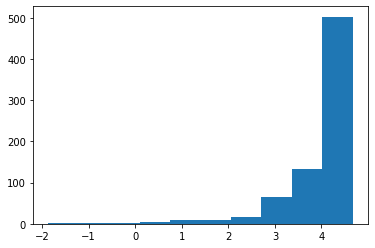

In [ ]:
plt.hist(ite)

Checking the means of Individual treatment effects after splitting the data:

In [ ]:
np.mean(ite_train),np.mean(ite_val),np.mean(ite_test)

####Random Forest Regression:

Training The Model:
Using three estimators for training the model:

Random forest regressor,
Random forest with Inverse Propensity Weighting (IPW),
X-learner with RF as base learners.

Concatenating X variable with 25 input features and T i.e treatment 
variable to train the model along with treatment.

In [ ]:
XT_train = np.concatenate((X_train,T_train),axis=1)

Fitting Random Forest Regressor on training data:



In [ ]:
rf = RandomForestRegressor()
rf.fit(XT_train, Yf_train.flatten())

RandomForestRegressor()

For validation of model, y1_val and y0_val are predicted by setting treatment to 1 and 0 respectively.Treatment variable (T=0,T=1) is again merged accordingly with X data.Predicted outcomes for both treated and controlled for each individuals as y1_val,y0_val and obtained treatement effect using ite=y1-y0.


In [ ]:
xt0_val = np.concatenate([X_val, np.zeros_like(T_val)], axis=1)
rf_y0_val = rf.predict(xt0_val)

xt1_val = np.concatenate([X_val, np.ones_like(T_val)], axis=1)
rf_y1_val = rf.predict(xt1_val)

rf_te_val = rf_y1_val - rf_y0_val
np.mean(rf_te_val)

Predictions using Test data:

y1_test and y0_test are predicted by setting treatment to 1 and 0 respectively.
Setting T to a 1 and 0 for all individuals using zeros_like and one_like and merge with X_test to obtain treatment effect estimates
Outcomes for both treated and controlled for each individuals as y1_test,y0_test and obtained treatement effect using ite=y1-y0

In [ ]:
xt0_test = np.concatenate([X_test, np.zeros_like(T_test)], axis=1)
rf_y0_test = rf.predict(xt0_test)

xt1_test = np.concatenate([X_test, np.ones_like(T_test)], axis=1)
rf_y1_test = rf.predict(xt1_test)

rf_te_test = rf_y1_test - rf_y0_test
np.mean(rf_te_test)

####RandomForestClassifier with Inverse Propensity Score(IPW):

Training using RandomForestClassifier extending with with the Inverse Propensity Weighting (IPW),to model unit's probability of receiving the treatment, P(ti|xi). This is a classic binary classification problem using input X,treatment T. P(ti|xi)  is called a propensity score.

To get the sample weights, get_ps_weights function is called from causalfuncs.py which is available at https://github.com/srigouri/CE888-Causal/blob/main/causalfuncs.py

In [ ]:
from causalfuncs import get_ps_weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, X_train, T_train)

rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(XT_train, Yf_train.flatten(), sample_weight=weights)

RandomForestRegressor()

Making Predictions using Classifier with Inverse Propensity Scores (IPSW) and computing ITE's.Mean of ITEs is calculated.

In [ ]:
rf_ipsw_y0_test =rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test =rf_ipsw.predict(xt1_test) 

rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test 
np.mean(rf_ipsw_te_test)

####X-Learner:
  X-learner is a meta-learner implemented via EconML. Uses provided regressors and classifiers to model and predict effect. We need not merge inputs and treatment to train the model. 

In [ ]:
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(Yf_train, T_train.flatten(), X=X_train)

xl_te_test = xl.effect(X_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


#### Evaluation

Metrics Chosen: ϵATE  and  ϵPEHE 

Confidence intervals of predicted ATEs

In [ ]:
# Using 'abs_ate' function from causalfuncs.py, true ITEs and predicted ITEs to get the measurements.
rf_ate_test = abs_ate(ite_test,rf_te_test)
rf_ipsw_ate_test = abs_ate(ite_test,rf_ipsw_te_test)
xl_ate_test = abs_ate(ite_test,xl_te_test) 


In [ ]:
# Using 'pehe' function from causalfuncs.py, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test =pehe(ite_test,rf_te_test) 
rf_ipsw_pehe_test = pehe(ite_test,rf_ipsw_te_test) 
xl_pehe_test = pehe(ite_test,xl_te_test) 

In [ ]:
results = []
results.append(['RF', rf_ate_test, rf_pehe_test])
results.append(['RF (IPW)', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['XL', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.255172,1.419627
1,RF (IPW),0.269152,1.408916
2,XL,0.037197,0.603823


#### Confidence Intervals

In [ ]:
rf_ate_bounds = mean_ci(rf_te_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_test)
xl_ate_bounds = mean_ci(xl_te_test)


results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df2 = pd.DataFrame(results, columns=cols)
df2

,Method,ATE mean,CI lower,CI upper
0,RF,3.789370,3.603386,3.975354
1,RF (IPW),3.775391,3.592077,3.958704
2,XL,4.007345,[3.8969790916952336],[4.117710903938456]


#### Visualizations

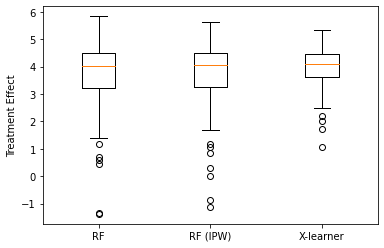

In [ ]:
plt.figure()
plt.boxplot([rf_te_test, rf_ipsw_te_test, xl_te_test.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

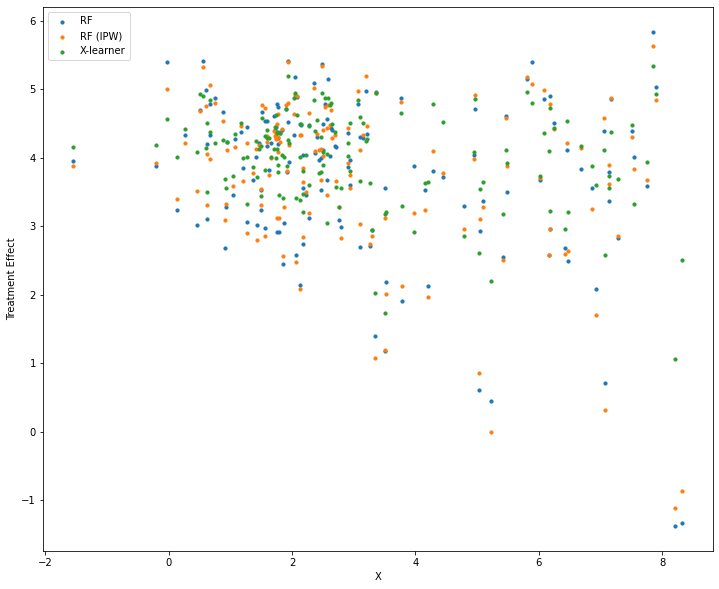

In [ ]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(Yf_test,rf_te_test, label="RF", s=m_size)
plt.scatter(Yf_test,rf_ipsw_te_test, label="RF (IPW)", s=m_size)
plt.scatter(Yf_test,xl_te_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()